In [1]:
import pandas as pd
from transformers import RobertaTokenizer, RobertaForSequenceClassification,get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
#import torch
import seaborn as sns
#import transformers
import json
from tqdm import tqdm
#from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

2024-04-16 10:17:04.826923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 10:17:04.827023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 10:17:04.970663: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# !unzip "/content/sentiment_analysis_data.zip"

In [3]:
df=pd.read_csv("/kaggle/input/dataset/sentiment_analysis_data/train.csv")
df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km),Density (P/Km)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [4]:
df.shape

(27481, 10)

In [5]:
# check class distribution
df['sentiment'].value_counts(normalize = True)

sentiment
neutral     0.404570
positive    0.312288
negative    0.283141
Name: proportion, dtype: float64

# Pre-process text

In [6]:
# import pandas as pd
# import string
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
import re

def preprocess_text(text):
    # Remove float objects
    if isinstance(text, float):
        return ''

    # Replace NaNs with space
    if pd.isna(text):
        return ''

    # Lowercase the text
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d', '', text)

    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Remove emails
    text = re.sub(r"\S*@\S*\s?", '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # # Tokenization
    # tokens = word_tokenize(text)

    # # Remove stopwords
    # stop_words = set(stopwords.words('english'))
    # tokens = [token for token in tokens if token not in stop_words]

    # # Join tokens back into a single string
    # preprocessed_text = ' '.join(tokens)

    return text

# Example usage:
# Assuming df is your DataFrame and 'text' is the column containing the text data
df['clean_text'] = df['text'].apply(preprocess_text)


In [7]:
# Define a dictionary to map original labels to encoded labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

# Map the original labels to encoded labels
df['encoded_sentiment'] = df['sentiment'].map(label_map)

# Split train dataset into train, validation and test sets

In [8]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['clean_text'], df['encoded_sentiment'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['encoded_sentiment'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [27]:
test_labels.value_counts()

encoded_sentiment
1    1668
2    1288
0    1167
Name: count, dtype: int64

# Import BERT Model and BERT Tokenizer

In [9]:
from transformers import BertTokenizer, TFBertForSequenceClassification
num_classes = 3

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
def convert_example_to_feature(review):
  return bert_tokenizer.encode_plus(review,
                add_special_tokens = True,     # add [CLS], [SEP]
                max_length = 512,              # max length of the text that can go to BERT
                padding='max_length',
                truncation=True,
                return_attention_mask = True,  # add attention mask to not focus on pad tokens
              )

In [11]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  for review, label in ds:
    bert_input = convert_example_to_feature(review)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)


In [12]:
batch_size = 8

In [13]:
ds_train = zip(train_text, train_labels)
ds_test = zip(test_text, test_labels)
ds_train_encoded = encode_examples(ds_train).shuffle(len(train_text)).batch(batch_size)
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

In [14]:
# log_dir = './sentiment-analysis-using-bert-keras/tensorboard_data/tb_bert'
model_save_path = 'bert_model.h5'

path = "/content/"

## Initialize pre-built BERT-based classifier from transformers
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=num_classes)

bert_model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109484547 (417.65 MB)
Trainable params: 109484547 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 4

# choosing Adam optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
optimizer = 'adam'
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=metric)

In [16]:
history = bert_model.fit(ds_train_encoded,
                         batch_size=batch_size,
                         epochs=number_of_epochs,
                         validation_data=ds_test_encoded)

Epoch 1/4
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1713262839.032657      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2405/2405 [==============================] - 1574s 614ms/step - loss: 1.1631 - accuracy: 0.3572 - val_loss: 1.1005 - val_accuracy: 0.2830
Epoch 2/4
2405/2405 [==============================] - 1464s 609ms/step - loss: 1.1733 - accuracy: 0.3580 - val_loss: 1.1338 - val_accuracy: 0.2830
Epoch 3/4
2405/2405 [==============================] - 1464s 609ms/step - loss: 1.1740 - accuracy: 0.3510 - val_loss: 1.1529 - val_accuracy: 0.3124
Epoch 4/4
2405/2405 [==============================] - 1464s 609ms/step - loss: 1.1725 - accuracy: 0.3567 - val_loss: 1.1191 - val_accuracy: 0.4046


In [17]:
bert_model.save_weights(model_save_path)

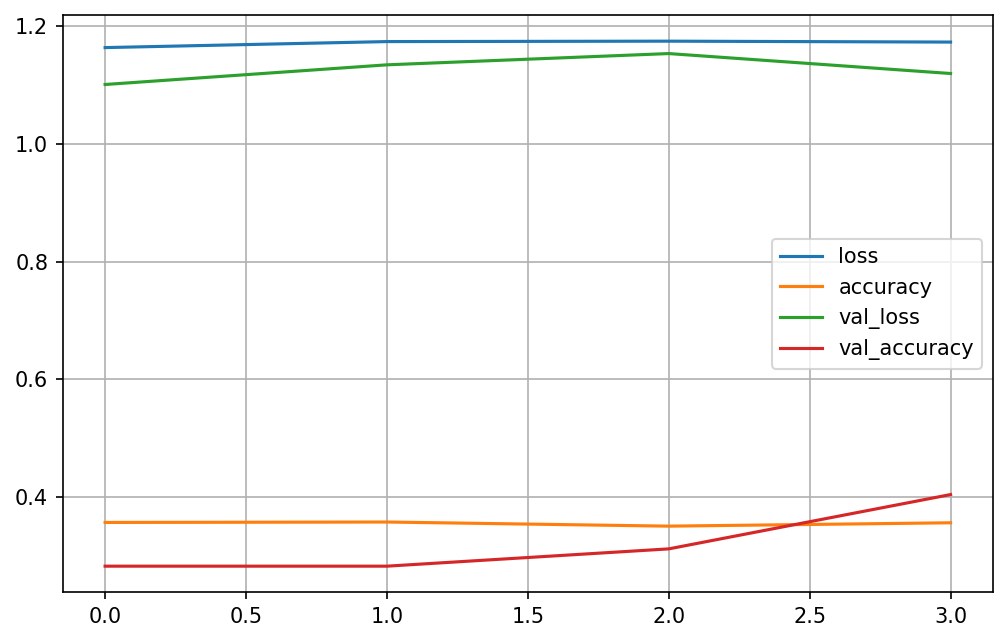

In [18]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

plot2(history)

In [19]:
bert_model.evaluate(ds_test_encoded,
                    batch_size=batch_size)

516/516 [==============================] - 103s 199ms/step - loss: 1.1191 - accuracy: 0.4046


[1.11910879611969, 0.40455979108810425]

In [20]:
y_test_pred = bert_model.predict(ds_test_encoded,
                                 batch_size=batch_size)

516/516 [==============================] - 111s 195ms/step


In [21]:
y_test_pred_class = y_test_pred[0].argmax(axis=1)

In [29]:
from sklearn.metrics import classification_report

# Calculate classification report
report = classification_report(test_labels, y_test_pred_class, target_names=class_labels)

# Manually format the classification report
formatted_report = report.replace('\n\n', '\n')
formatted_report = formatted_report.replace('           ', ' ')

# Print the formatted classification report
print("Classification Report:")
print(formatted_report)


Classification Report:
    precision    recall  f1-score   support
    negative       0.00      0.00      0.00      1167
     neutral       0.40      1.00      0.58      1668
    positive       0.00      0.00      0.00      1288
    accuracy       0.40      4123
   macro avg       0.13      0.33      0.19      4123
weighted avg       0.16      0.40      0.23      4123



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


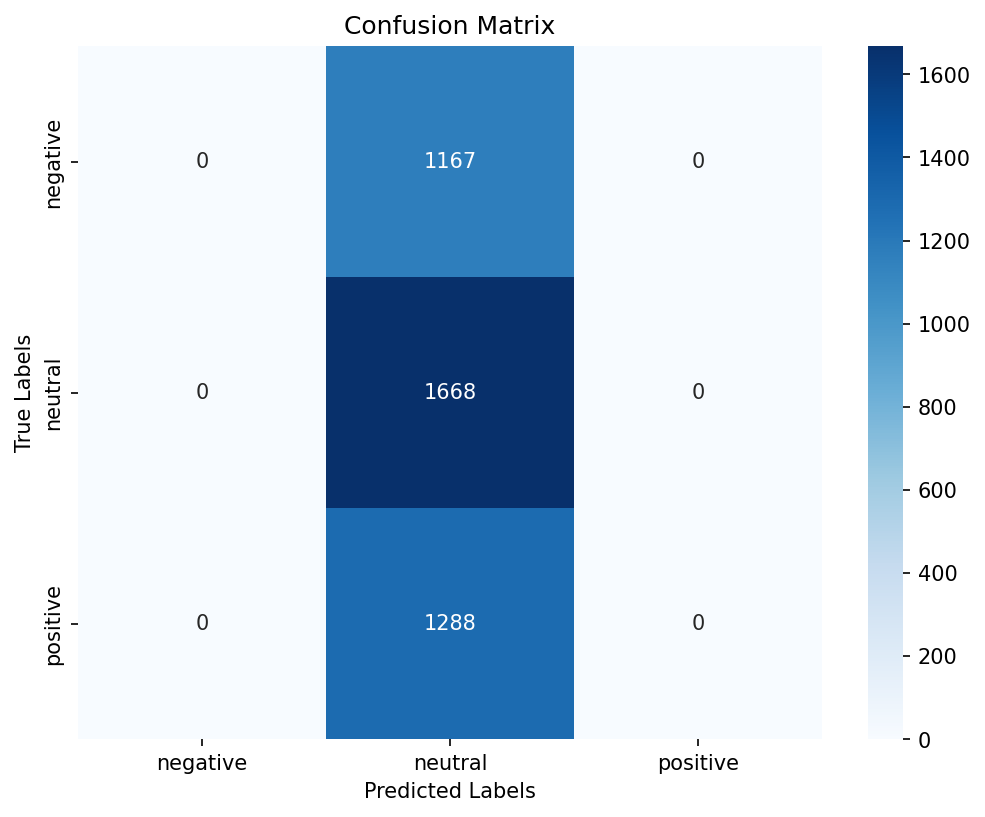

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define custom class labels
class_labels = ['negative', 'neutral', 'positive']

# Calculate confusion matrix
cm = confusion_matrix(test_labels, y_test_pred_class)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
